In [40]:
import os
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from learned_tuning.learned_tuning import calculate_learned_tuning_PBE_subsets, calculate_place_field_fidelity_of_learned_tuning, calculate_all_column_correlations


%matplotlib widget


def gausswindow(sigma, halfwidth):
    """
    Compute a Gaussian window function.

    Parameters
    ----------
    sigma : float
        Standard deviation of the Gaussian distribution.
    halfwidth : int
        Half the length of the window.

    Returns
    -------
    win : numpy.ndarray
        The Gaussian window function.

    """
    mu = 0
    x = np.arange(mu - halfwidth, mu + halfwidth + 1)
    y = np.zeros(x.shape)
    
    for i in range(len(x)):
        y[i] = (1/(sigma*np.sqrt(2*np.pi))) * np.exp(-(x[i] - mu)**2 / (2*sigma**2))
    
    win = y/np.sum(y)
    
    return win


z_score = lambda x:(x-np.nanmean(x)) /np.nanstd(x) # the function to calculate z-score

normalize_to_max = lambda x:(x/np.nanmax(x))


main_dir = '/home/kouroshmaboudi/Documents/Learned_tuning_Python/Datasets/'
matlab_data_dir = r'/home/kouroshmaboudi/Documents/NCMLproject/assemblyTuning_finalResults/'

rr = os.listdir(main_dir)

current_sessions = [x for x in range(17) if x not in (5, 9, 10, 12, 13)] # RatV sessions for now and Roy familiar sessions were excluded
current_sessions.append(5)


number_of_sessions = len(current_sessions)

epoch_names = ['pre', 'maze', 'post']


num_units = np.empty((number_of_sessions,), dtype=int)
active_units = np.empty((number_of_sessions,), dtype=object)
each_unit_session_number = np.empty((number_of_sessions,), dtype=object) # to keep track of session identity for each unit when we pool together and sort the units from diferent sessions

spatial_tunings_maze = np.empty((number_of_sessions,), dtype=object) # spatial tunings on MAZE

learned_tunings = np.empty((number_of_sessions,), dtype=object)
learned_tunings_place_field_corr = np.empty((number_of_sessions,), dtype=object)
learned_tunings_place_field_corr_unit_id_shuffle = np.empty((number_of_sessions,), dtype=object)

gw = gausswindow(3, 9) # for smoothing the tunings 
flag = 1

for session_idx in range(number_of_sessions):

    session_number = current_sessions[session_idx]
    session_name = rr[session_number]

    print(session_name + " " + str(session_idx+1) + "/" + str(number_of_sessions))


    session_dataset_path = os.path.join(main_dir, session_name)


    # Load epochs information
    filename = f'{session_name}.fileInfo_for_python.mat'
    file_path = os.path.join(session_dataset_path, filename)

    mat_file = loadmat(file_path)
    session_info = mat_file["fileInfo"]

    epochs = session_info["behavior"][0][0][0][0]["time"]
    epoch_durations = epochs[:, 1] - epochs[:, 0]



    """
    spatial tunings during MAZE and reMAZE
    """

    spikes_pyr = loadmat(os.path.join(session_dataset_path, session_name + '.spikes_for_python.mat'))['spikes_pyr']
    
    if session_number in [6, 7]: # RatN and RatS
        num_units_total = spikes_pyr["spatialTuning_smoothed"].shape[0] # for RatN only
    else:
        num_units_total = spikes_pyr["spatialTuning_smoothed"][0].shape[0]

    num_pos_bins = spikes_pyr["spatialTuning_smoothed"][0][0]['uni'][0][0].size



    # Load unit stability information
    filename = f'{session_name}.cluster_quality_by_block'
    file_path = os.path.join(session_dataset_path, filename)

    mat_file = loadmat(file_path)
    cluster_quality_by_block = mat_file['cluster_quality_by_block'][0]


    
    spikes = [] # spike data and place field info of each unit

    # attributes = list(spikes_pyr.dtype.names) % if we want to work on all variable in the imported .mat data structure
    running_directions = {'LR', 'RL', 'uni'}
    other_attributes   = {'spike_times', 'shank_id','cluster_id'}

    iter = 0
    for unit in range(num_units_total):
        
        # Create dictionaries for each unit and store the matrices
        unit_spikes = dict()
        
        unit_spikes['place_fields_maze']  = {}
        unit_spikes['peak_pos_bins_maze'] = {}
        # unit_spikes['peak_firing_rate'] = {}

        for direction in running_directions:
            try:
                if session_number in [6, 7]:    
                    unit_spikes['place_fields_maze'][direction] = spikes_pyr["spatialTuning_smoothed"][unit][0][direction][0][0].reshape(num_pos_bins) 
                    unit_spikes['peak_pos_bins_maze'][direction] = spikes_pyr['peakPosBin'][unit][0][direction][0][0][0][0]
                    # unit_spikes['peak_firing_rate'][direction] = spikes_pyr['peakFR'][unit][0][direction][0][0][0][0]
                else:
                    unit_spikes['place_fields_maze'][direction] = spikes_pyr["spatialTuning_smoothed"][0][unit][direction][0][0].reshape(num_pos_bins) 
                    unit_spikes['peak_pos_bins_maze'][direction] = spikes_pyr['peakPosBin'][0][unit][direction][0][0][0][0]
                    # unit_spikes['peak_firing_rate'][direction] = spikes_pyr['peakFR'][0][unit][direction][0][0][0][0]

            except ValueError:
                if iter == 0:
                    print("This session has only one running direction")
                iter += 1

        if session_number in [9, 10]: # for Rat V sessions
            unit_spikes['spike_times'] = spikes_pyr['time'][0][unit]
            unit_spikes['shank_id']    = spikes_pyr['id'][0][unit][0][1] 
            unit_spikes['cluster_id']  = spikes_pyr['id'][0][unit][0][0]

        elif session_number in [6, 7]: # for RatN and RatS
            unit_spikes['spike_times'] = spikes_pyr['time'][unit][0] 
            unit_spikes['shank_id']    = spikes_pyr['id'][unit][0][0][0]-1
            unit_spikes['cluster_id']  = spikes_pyr['id'][unit][0][0][1]

        elif session_number == 8: # RatU  
            unit_spikes['spike_times'] = spikes_pyr['time'][0][unit]
            unit_spikes['shank_id']    = spikes_pyr['id'][0][unit][0][0] # shank indices already starts at zero
            unit_spikes['cluster_id']  = spikes_pyr['id'][0][unit][0][1]

        else:
            unit_spikes['spike_times'] = spikes_pyr['time'][0][unit]
            unit_spikes['shank_id']    = spikes_pyr['id'][0][unit][0][0]-1 # need to go one down for the other datasets
            unit_spikes['cluster_id']  = spikes_pyr['id'][0][unit][0][1]


        # Extract the cluster quality information by block for the current unit  
        curr_unit_idx = np.where(cluster_quality_by_block['cluster_ids'][unit_spikes['shank_id']] == unit_spikes['cluster_id'])[0]
        
        spike_amplitude_by_block = cluster_quality_by_block['spike_amplitude_by_block'][unit_spikes['shank_id']][curr_unit_idx]
        spike_amplitude_by_block = np.nan_to_num(spike_amplitude_by_block, nan=0)
        spike_amplitude_by_block_percent = spike_amplitude_by_block/cluster_quality_by_block['session_mean_spike_amplitude'][unit_spikes['shank_id']][curr_unit_idx]# as a percentage of session mean
        unit_spikes['spike_amplitude_by_block'] = spike_amplitude_by_block_percent

        firing_rate_by_block = cluster_quality_by_block['firing_rate_by_block'][unit_spikes['shank_id']][curr_unit_idx]
        firing_rate_by_block = np.nan_to_num(firing_rate_by_block, nan=0)
        # firing_rate_by_block_percent = firing_rate_by_block/cluster_quality_by_block['session_mean_firing_rate'][unit_spikes['shank_id']][curr_unit_idx]
        if firing_rate_by_block.shape[1] == 2: 
            sleep_firing_rate = (firing_rate_by_block[0][0]*epoch_durations[0] + firing_rate_by_block[0][1]*epoch_durations[2])/np.sum(epoch_durations[[0,2]])
        elif firing_rate_by_block.shape[1] == 3:
            sleep_firing_rate = (firing_rate_by_block[0][0]*epoch_durations[0] + firing_rate_by_block[0][1]*4*3600 + firing_rate_by_block[0][2]*(epoch_durations[2]-4*3600))/np.sum(epoch_durations[[0,2]])

        if sleep_firing_rate > 0:
            firing_rate_by_block_percent = firing_rate_by_block/sleep_firing_rate
        else:
            firing_rate_by_block_percent = np.zeros((len(firing_rate_by_block),))

        unit_spikes['firing_rate_by_block'] = firing_rate_by_block_percent                

        isolation_distance_by_block = cluster_quality_by_block['isolation_distance_by_block'][unit_spikes['shank_id']][curr_unit_idx]
        isolation_distance_by_block = np.nan_to_num(isolation_distance_by_block, nan=0)
        unit_spikes['isolation_distance_by_block'] = isolation_distance_by_block


        try:
            unit_spikes['pre_post_unit_stability'] = (
                # (unit_spikes['spike_amplitude_by_block'][0][:2] > 0.9) & 
                (unit_spikes['firing_rate_by_block'][0][:2] > 0.33) & 
                (unit_spikes['isolation_distance_by_block'][0][:2] > 15)
            ).all()
        except:
            unit_spikes['pre_post_unit_stability'] = np.nan



        spikes.append(unit_spikes) 


    # # load MAZE PF stability
    # maze_place_field_stabilities_curr_session = loadmat(os.path.join(session_dataset_path, session_name + '.PFstability.mat'))['PF_stability_across_blocks']


    """
    Learned tunings during different epochs
    """
    
    # Load .mat file
    mat_file = loadmat(os.path.join(session_dataset_path, session_name + '.assemblyTuning_vs_replayScores_Lthresh1e_3_wcts.mat'))
    
    learned_tunings_curr_session = dict()
    for epoch_index, epoch in enumerate(epoch_names):
        if epoch == 'maze':
            epoch_name_read = 'run'
        else:
            epoch_name_read = epoch
        learned_tunings_for_replay_scores_quartiles = mat_file['assemblyTunings_sub'][epoch_name_read][0][0][0][0][0]['data'][0][0]

        for replay_score_quartile_index in range(4):
            learned_tunings_curr_session[f'{epoch}-quartile{replay_score_quartile_index}'] = learned_tunings_for_replay_scores_quartiles[:, :, replay_score_quartile_index]

    condition_names = list(learned_tunings_curr_session.keys())



    interp_pos_bins = np.linspace(0, num_pos_bins, 200)
    num_pos_bins_interp = len(interp_pos_bins)

    spatial_tunings_maze[session_idx] = np.zeros((num_units_total, num_pos_bins_interp))
    pre_post_unit_stability_curr_session = np.empty((num_units_total,))
    # peak_place_field_fr = np.full((num_units_total,), np.nan)

    for unit in range(len(spikes)):

        spatial_tuning_maze_curr_unit = spikes[unit]['place_fields_maze']['uni']
        # peak_place_field_fr[unit] = spikes[unit]['peak_firing_rate']['uni']

        spatial_tuning_maze_curr_unit = np.interp(interp_pos_bins, np.arange(1, num_pos_bins+1), spatial_tuning_maze_curr_unit)

        """
        Normalize the spatial tunings; zscoring (for multiple regression analysis), or set the max amplitude to one (for plotting the heatmaps)
        """
        spatial_tunings_maze[session_idx][unit] = spatial_tuning_maze_curr_unit
        # spatial_tunings_maze[session_idx][unit] = z_score(spatial_tuning_maze_curr_unit)
        # spatial_tunings_maze[session_idx][unit] = normalize_to_max(spatial_tuning_maze_curr_unit) 

        pre_post_unit_stability_curr_session[unit] = spikes[unit]['pre_post_unit_stability']
          
          
    active_units[session_idx] = np.where((np.nanmax(spatial_tunings_maze[session_idx], axis=1) > 1) & (pre_post_unit_stability_curr_session == True))[0]
    num_units[session_idx] = len(active_units[session_idx])
    

    # spatial_tunings_maze[session_idx] = np.apply_along_axis(normalize_to_max, 1, spatial_tunings_maze[session_idx])


    spatial_tunings_maze[session_idx] = spatial_tunings_maze[session_idx][active_units[session_idx]]
    spatial_tunings_maze[session_idx][np.isnan(spatial_tunings_maze[session_idx])] = 1e-16

    learned_tunings[session_idx] = dict()
    learned_tunings_place_field_corr[session_idx] = dict()
    learned_tunings_place_field_corr_unit_id_shuffle[session_idx] = dict()
    num_shuffles = 10000

    for epoch, epoch_name in enumerate(condition_names): 

        learned_tunings[session_idx][epoch_name] = np.full((num_units[session_idx].item(), num_pos_bins_interp), np.nan)

        for unit in range(num_units[session_idx].item()):
            curr_unit_learned_tuning = learned_tunings_curr_session[epoch_name][active_units[session_idx][unit]].reshape(num_pos_bins)
            curr_unit_learned_tuning = np.interp(interp_pos_bins, np.arange(1, num_pos_bins+1), curr_unit_learned_tuning)
            curr_unit_learned_tuning[np.isnan(curr_unit_learned_tuning)] = 0

            # An additional smoothing of the learned tunings during the sleep epochs
            if epoch_name not in ['maze_theta']: # PRE, MAZE, POST, or latePOST
                curr_unit_learned_tuning = np.convolve(curr_unit_learned_tuning, gw, mode='same')


            # Normalize
            learned_tunings[session_idx][epoch_name][unit] = curr_unit_learned_tuning
            # learned_tunings[session_idx][epoch_name][unit] = z_score(curr_unit_learned_tuning)
            # learned_tunings[session_idx][epoch_name][unit] = normalize_to_max(curr_unit_learned_tuning)

        # recalculate the correlation between learned tunings and MAZE place fields
        (learned_tunings_place_field_corr[session_idx][epoch_name],
        learned_tunings_place_field_corr_unit_id_shuffle[session_idx][epoch_name],
        _) = calculate_place_field_fidelity_of_learned_tuning(
                learned_tunings[session_idx][epoch_name],
                spatial_tunings_maze[session_idx],
                num_shuffles
            )
        
    each_unit_session_number[session_idx] = np.full((num_units[session_idx],), session_number)


Achilles_10252013 1/13
Achilles_11012013 2/13
This session has only one running direction
Buddy_06272013 3/13
Cicero_09172014 4/13
Gatsby_08282013 5/13
This session has only one running direction
RatN_Day2_2019-10-11_03-58-54 6/13
RatS-Day2-2020-11-27_10-22-29 7/13
RatU_Day2NSD_2021-07-24_08-16-38 8/13
Roy-maze1 9/13
Ted-maze1 10/13
Ted-maze2 11/13
Ted-maze3 12/13
Kevin-maze1 13/13


### Concatenate across the sessions

In [60]:
# Concatenate place fields from all sessions and sort them according to the peak place field locations
spatial_tunings_maze_sessions_concat = np.concatenate(spatial_tunings_maze, axis=0)


each_unit_session_number_sessions_concat = np.concatenate(each_unit_session_number, axis=0)


# learned tunings
learned_tunings_sessions_concat = dict.fromkeys(condition_names)
learned_tunings_place_field_population_vector_correlation = dict.fromkeys(condition_names)
for epoch, condition in enumerate(condition_names):
    temp = []
    for session_idx in range(number_of_sessions):
        temp.append(learned_tunings[session_idx][condition])
    learned_tunings_sessions_concat[condition] = np.concatenate(temp, axis = 0)


    # Population vector correlation between the learned tunings and the place fields
    
    all_zero_LT_unit_index = np.sum(learned_tunings_sessions_concat[condition], axis=1) == 0

    current_place_fields = np.apply_along_axis(normalize_to_max, 1, spatial_tunings_maze_sessions_concat)
    current_learned_tuning = np.apply_along_axis(normalize_to_max, 1, learned_tunings_sessions_concat[condition])

    learned_tunings_place_field_population_vector_correlation[condition] = calculate_all_column_correlations(current_place_fields[~all_zero_LT_unit_index], current_learned_tuning[~all_zero_LT_unit_index])



learned_tunings_place_field_corr_sessions_concat = dict.fromkeys(condition_names)
learned_tunings_place_field_corr_unit_id_shuffle_concat = dict.fromkeys(condition_names)
lt_pf_correlation_median_across_all_sessions = dict.fromkeys(condition_names)
lt_pf_correlation_median_across_all_sessions_pvalue = dict.fromkeys(condition_names)

for epoch, condition in enumerate(condition_names):
    # data
    temp = []
    for session_idx in range(number_of_sessions):
        temp.append(learned_tunings_place_field_corr[session_idx][condition])
    learned_tunings_place_field_corr_sessions_concat[condition] = np.concatenate(temp, axis = 0)

    # shuffle
    temp = []
    for session_idx in range(number_of_sessions):
        temp.append(learned_tunings_place_field_corr_unit_id_shuffle[session_idx][condition])
    learned_tunings_place_field_corr_unit_id_shuffle_concat[condition] = np.concatenate(temp, axis = 0)


    # calculate the p-values of place fidelities
    lt_pf_correlation_median_across_all_sessions[condition] = np.nanmedian(learned_tunings_place_field_corr_sessions_concat[condition])  
    ui_lt_pf_correlation_medians = np.nanmedian(learned_tunings_place_field_corr_unit_id_shuffle_concat[condition], axis = 0)

    lt_pf_correlation_median_across_all_sessions_pvalue[condition] = np.sum(ui_lt_pf_correlation_medians >= lt_pf_correlation_median_across_all_sessions[condition])/num_shuffles


/tmp/ipykernel_64918/114517359.py:44: RuntimeWarning: invalid value encountered in divide
  normalize_to_max = lambda x:(x/np.nanmax(x))


### Plot the learned tunings and population vector correlations

/tmp/ipykernel_64918/114517359.py:44: RuntimeWarning: invalid value encountered in divide
  normalize_to_max = lambda x:(x/np.nanmax(x))


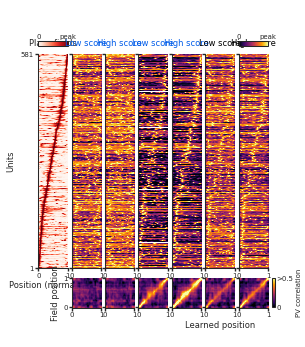

In [184]:

colors = [
    '#005CE9', # PRE
    'black',# MAZE
    '#DD335D' # # POST
    ] 

def get_epoch_color(i):
    if i<= 3:
        color = colors[0]    
    elif i <=7:
        color = colors[1]
    else:
        color = colors[2]
    return color

def get_pval_statement(pvalue):
    if pvalue < 0.0001:
        pvalue_statement = 'P<1e-4'
    else:
        pvalue_statement = f'P={pvalue:.4f}'
    return pvalue_statement
        

sns.set_style('whitegrid')
sns.set_context('paper')

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

plt.rcParams.update({
    'font.size':6,
    'axes.linewidth':0.75,
    'pdf.fonttype':42,
    'ps.fonttype':42,
    'axes.labelsize':5,
    'axes.titlesize':6,
    'xtick.labelsize':5,
    'ytick.labelsize':5,
    'legend.fontsize':5,
    'legend.title_fontsize':5,
    'legend.frameon': False,
    'legend.markerscale':2,
    'xtick.major.size':2,
    'ytick.major.size':2
})



# Create figure and subplots
plotheight = 250
plotwidth = 220
font_size = 6

condition_names_to_plot = ['pre-quartile0',
                   'pre-quartile3',
                   'maze-quartile0',
                   'maze-quartile3',
                   'post-quartile0',
                   'post-quartile3']


fig = plt.figure()
fig.set_size_inches([plotwidth/72, plotheight/72])
gs = GridSpec(nrows=3, ncols=len(condition_names_to_plot)+2, figure=fig, height_ratios=[0.02, 1, 0.15], width_ratios=[1]*(len(condition_names_to_plot)+1)+[0.1], wspace = 0.15, hspace = 0.1)


c_map = 'inferno'


# plot MAZE place fields
ax0 = fig.add_subplot(gs[1, 0])

place_fields_peak_locations = np.argmax(spatial_tunings_maze_sessions_concat, axis=1)
place_fields_sort_idx = np.argsort(place_fields_peak_locations)

current_data = spatial_tunings_maze_sessions_concat[place_fields_sort_idx]
current_data = np.apply_along_axis(normalize_to_max, 1, current_data)

ax0.imshow(current_data, vmin=0, vmax=1, cmap='Reds', aspect='auto', interpolation='none', origin='lower')
ax0.set_xticks([0, num_pos_bins_interp])
ax0.set_xticklabels(['0', '1'])
ax0.set_yticks([0, spatial_tunings_maze_sessions_concat.shape[0] - 1])
ax0.set_yticklabels(['1', str(spatial_tunings_maze_sessions_concat.shape[0])])
ax0.set_ylabel('Units', fontsize = font_size)

ax0.set_xlabel('Position (normalized)', fontsize = font_size, labelpad=2)
ax0.set_title('Place fields', fontsize = font_size)
ax0.tick_params(axis='both', which='major', labelsize=5, length=2, width=1, pad=1)


# plot colorbar for the place fields
ax0_cbar = fig.add_subplot(gs[0, 0])
cbar = plt.colorbar(ax0.get_images()[0], cax = ax0_cbar, orientation = 'horizontal', drawedges = False)
cbar.set_ticks([0, 1])
cbar.set_ticklabels([0, 'peak'])
cbar.ax.tick_params(length=0, pad=1)
cbar.ax.xaxis.set_ticks_position('top')


# plot condition's learned tunigs
for i, condition in enumerate(condition_names_to_plot):
    ax1 = fig.add_subplot(gs[1, i+1])

    current_data = learned_tunings_sessions_concat[condition][place_fields_sort_idx]
    current_data = np.apply_along_axis(normalize_to_max, 1, current_data)

    ax1.imshow(current_data, vmin=0, vmax=1, cmap=c_map, aspect='auto', interpolation='none', origin='lower')
    ax1.set_xticks([0, num_pos_bins_interp])
    ax1.set_xticklabels(['0', '1'])
    ax1.set_yticks([0, spatial_tunings_maze_sessions_concat.shape[0] - 1], [])
    ax1.tick_params(axis='both', which='major', labelsize=5, length=2, width=1, pad=1)
    
    if i%2 == 0:
        title = 'Low score'
    else:
        title = 'High score'
    ax1.set_title(title, color= get_epoch_color(i))


ax1_cbar = fig.add_subplot(gs[0, i+1])
cbar = plt.colorbar(ax1.get_images()[0], cax = ax1_cbar, orientation = 'horizontal', drawedges = False)
cbar.set_ticks([0, 1])
cbar.set_ticklabels([0, 'peak'])
cbar.ax.tick_params(length=0, pad=1)
cbar.ax.xaxis.set_ticks_position('top')


# plot population vector correlations between position bins in learned tunings and place fields

max_correlation = 0.5
for i, condition in enumerate(condition_names_to_plot):
    ax2 = fig.add_subplot(gs[2, i+1])

    ax2.imshow(learned_tunings_place_field_population_vector_correlation[condition], vmin=0, vmax=max_correlation, cmap=c_map, aspect='auto', interpolation='none', origin='lower') # np.amax(learned_tunings_place_field_population_vector_correlation[condition])
    ax2.set_xticks([0, num_pos_bins_interp-1])
    ax2.set_xticklabels(['0', '1'])

    ax2.set_yticks([0, num_pos_bins_interp])
    if i == 0:
        ax2.set_yticklabels(['0', '1'])
    else:
        ax2.set_yticklabels([])
    

    if i==0:
        ax2.set_ylabel('Field position', fontsize = font_size, labelpad=2)

    if i==4:    
        ax2.set_xlabel('Learned position', fontsize = font_size, labelpad=2)

    ax2.tick_params(axis='both', which='major', labelsize=5, length=2, width=1, pad=1)
    ax2.set_aspect('equal')

ax2_cbar = fig.add_subplot(gs[2, i+2])
cbar = plt.colorbar(ax2.get_images()[0], cax = ax2_cbar, orientation = 'vertical', drawedges = False)
cbar.set_label("PV correlation", labelpad=2)
cbar.set_ticks([0, max_correlation])
cbar.set_ticklabels([0, f'>{max_correlation}'])
cbar.ax.tick_params(length=0, pad=1)
cbar.ax.xaxis.set_ticks_position('top')
ax2_cbar.set_aspect(20)


plt.show()

filename = 'Learned_tuning_vs_replay_quartiles.pdf'
file_path = os.path.join(main_dir, filename)
plt.savefig(file_path, format='pdf', dpi=300)


### Plot the distribution of LT fidelity correspondong to each replay score quartile

/tmp/ipykernel_64918/1126159551.py:84: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i, (text, handle) in enumerate(zip(legend.get_texts(), legend.legendHandles)):


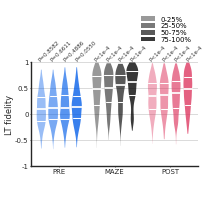

In [186]:
import pandas as pd
import matplotlib.ticker as ticker
from scipy.stats import friedmanchisquare 



#--------------------------------------------------------------------------------------------
# Define functions

def get_dataframe(data):

    num_units = data['pre-quartile0'].shape[0]

    epochs = []
    quartile_indexes = []
    lt_fidelity_column_values = []

    for condition in list(data.keys()):
        
        parts = condition.split('-')
        curr_epoch = parts[0]
        curr_quartile_index = int(parts[1][-1])
        
        epochs.extend([curr_epoch]*num_units)
        quartile_indexes.extend([curr_quartile_index]*num_units)
        lt_fidelity_column_values.extend(data[condition])

    df = pd.DataFrame({
        "epoch": epochs,
        "replay_quartile": quartile_indexes,
        "LT_fidelities": lt_fidelity_column_values
    })

    return df




def plot_violin(ax, data, xvar, yvar, zvar, colors):

    """
    customized Seaborn violon plot
    """

    alpha = 0.8
    vio = sns.violinplot(data=data, x = xvar, y = yvar, hue = zvar, scale_hue=0, cut=0, inner='quartiles', ax=ax, linewidth=0, width = .85,capstyle='butt')
    for violin, curr_alpha in zip(ax.collections[::1], [alpha] * 12):
        violin.set_alpha(curr_alpha)
    for l in ax.lines:
        l.set_linestyle('-')
        l.set_linewidth(0.75)
        l.set_color('white')
        l.set_alpha(1)
    for l in ax.lines[1::3]:
        l.set_linestyle('-')
        l.set_linewidth(1.25)
        l.set_color('white')
        l.set_alpha(1)
    ax.grid(axis='y', color=(.8,.8,.8), linewidth=0.5)

    for axis in ['left', 'bottom']:
        ax.spines[axis].set_linewidth(1)

    violin_elements = vio.collections
    for i, elem in enumerate(violin_elements):
        if i <= 3:
            current_color = colors[0]
        elif i <= 7:
            current_color = colors[1]
        elif i <= 11:
            current_color = colors[2]

        current_alpha = ((i%4)/4) * .5 + .4

        elem.set_facecolor(current_color)  # Filled with the same color
        elem.set_edgecolor("none")
        elem.set_alpha(current_alpha)

    vio.set_title("")
    legend = ax.legend(title=None, loc='upper right', bbox_to_anchor=(1, 1.5), fontsize = 5, labelspacing = 0.1)

    # Loop through legend elements and customize colors and alpha
    labels = ['0-25%', '25-50%', '50-75%', '75-100%']
    for i, (text, handle) in enumerate(zip(legend.get_texts(), legend.legendHandles)):
        text.set_text(labels[i%4])
        text.set_color('black')  # Set legend text color
        handle.set_edgecolor("none")  # Set legend handle edge color
        handle.set_facecolor('black')  # Set legend handle face color
        handle.set_alpha(((i%4)/4) * .5 + .4)  # Set alpha transparency level



def get_pval_statement(pvalue):
    if pvalue < 0.0001:
        pvalue_statement = 'P<1e-4'
    else:
        pvalue_statement = f'P={pvalue:.4f}'
    return pvalue_statement

def remove_trailing_zeros(x, pos):
    formatted_label = f"{int(x):d}" if x == int(x) else f"{x:.1f}"
    return formatted_label

#----------------------------------------------------------------------------------------------
# Set plot style and context

sns.set_style('whitegrid') 
sns.set_context('paper')

custom_params = {
    "axes.spines.top": False,
    "axes.spines.right": False
    }

sns.set_theme(style="ticks", rc=custom_params)

plt.rcParams.update({
    'font.size':5,
    'axes.linewidth':0.75,
    'pdf.fonttype':42,
    'ps.fonttype':42,
    'axes.labelsize':6,
    'axes.titlesize':8,
    'xtick.labelsize':5,
    'ytick.labelsize':5,
    'legend.fontsize':6,
    'legend.title_fontsize':6,
    'legend.frameon': False,
    'legend.markerscale':2,
    'xtick.major.size':2,
    'ytick.major.size':2
})

def format_ticks(x, _):
    if x == int(x):
        return str(int(x))
    else:
        return str(x)


# set plot size nnd create a plot
plotheight = 150
plotwidth = 150
font_size = 5

fig = plt.figure()
fig.set_size_inches([plotwidth/72, plotheight/72])
gs = GridSpec(nrows=1, ncols=1, figure=fig, hspace=0.3, wspace=0.3)

ax0 = fig.add_subplot(gs[0])

lt_fidelity_df = get_dataframe(learned_tunings_place_field_corr_sessions_concat)
plot_violin(ax0, lt_fidelity_df, "epoch", "LT_fidelities", "replay_quartile", colors)

ax0.set_ylim([-1, 1])
ax0.set_yticks(np.arange(-1, 1.01, .5))
ax0.set_ylabel('LT fidelity', labelpad = 1)
ax0.yaxis.set_major_formatter(ticker.FuncFormatter(remove_trailing_zeros))

xticklabels = ['PRE', 'MAZE', 'POST']
ax0.set_xticklabels(xticklabels, ha = 'center')
ax0.set_xlabel('')

epoch_indexes = {'pre': 0, 'maze':1, 'post':2}
for condition_index, condition in enumerate(condition_names):
    parts = condition.split('-')
    current_epoch_index = epoch_indexes[parts[0]]

    x_pos = current_epoch_index + 0.22 *(condition_index%4) - 0.38
    ax0.text(x_pos, 1.02, get_pval_statement(lt_pf_correlation_median_across_all_sessions_pvalue[condition]), fontsize = 4, color = 'black', alpha = 0.8, ha='left', rotation = 45)

friedman_pvalue = dict.fromkeys(epoch_names)
for epoch in epoch_names:
    quartile0 = learned_tunings_place_field_corr_sessions_concat[f'{epoch}-quartile0']
    quartile1 = learned_tunings_place_field_corr_sessions_concat[f'{epoch}-quartile1']
    quartile2 = learned_tunings_place_field_corr_sessions_concat[f'{epoch}-quartile2']
    quartile3 = learned_tunings_place_field_corr_sessions_concat[f'{epoch}-quartile3']

    valid_indexes = ~np.isnan(quartile0) & ~np.isnan(quartile1) & ~np.isnan(quartile2) & ~np.isnan(quartile3)  
    _, friedman_pvalue[epoch] = friedmanchisquare(quartile0[valid_indexes], quartile1[valid_indexes], quartile2[valid_indexes], quartile3[valid_indexes])

ax0.tick_params(axis='both', which='major', length=1, pad=1, width=0.5, labelsize = 5)

plt.subplots_adjust(left=0.15, right= 0.95, bottom=0.2, top=0.7)

filename = 'LT_fidelity_replay_score_quartiles.pdf'
file_path = os.path.join(main_dir, filename)
plt.savefig(file_path, dpi=300)

plt.show()

In [183]:
friedman_pvalue

{'pre': 0.012718107974416387,
 'maze': 7.733139345759765e-31,
 'post': 6.127758406089705e-38}